In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import logging

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from active_learning_ratio_estimation.active_learning.active_learner import ActiveLearner
from active_learning_ratio_estimation.dataset import ParamIterator, ParamGrid, SinglyParameterizedRatioDataset
from active_learning_ratio_estimation.model import FlipoutClassifier, SinglyParameterizedRatioModel

In [3]:
# make logger output only INFO from active_learning_ratio_estimation
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "active_learning_ratio_estimation" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [4]:
def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [5]:
theta_bounds = (0, 1)
theta_0 = 0.05
theta_1_iterator = ParamGrid(bounds=[theta_bounds], num=5)
num_grid = 101
n_samples_per_theta = int(1e2)
param_grid = ParamGrid(bounds=[theta_bounds], num=num_grid)

In [6]:
test_param_points = 10
test_iterator = ParamIterator([np.random.rand(1) for _ in range(test_param_points)])
test_dataset = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=triple_mixture,
    theta_0=theta_0,
    theta_1_iterator=test_iterator,
    n_samples_per_theta=n_samples_per_theta,
    include_log_probs=True
)

In [7]:
estimator = FlipoutClassifier(
    n_hidden=(15, 15),
    epochs=1,
    patience=0,
    validation_split=0.1,
    verbose=0,
)
ratio_model = SinglyParameterizedRatioModel(estimator=estimator)

In [8]:
learners = dict()
test_mses = dict()
acquisition_functions = [
    'std_regressor',
    'random',
]
n_iter = 10

In [9]:
for acquisition_function in acquisition_functions:
    print(f'\n**** Fitting with {acquisition_function} ****\n')
    active_learner = ActiveLearner(simulator_func=triple_mixture,
                                   theta_0=theta_0,
                                   theta_1_iterator=theta_1_iterator,
                                   n_samples_per_theta=n_samples_per_theta,
                                   ratio_model=ratio_model,
                                   total_param_grid=param_grid,
                                   test_dataset=test_dataset,
                                   acquisition_function=acquisition_function,
                                   ucb_kappa=0.0)
    active_learner.fit(n_iter)
    learners[acquisition_function] = active_learner
    test_mses[acquisition_function] = active_learner.test_history['mse'].values


**** Fitting with std_regressor ****

Instructions for updating:
Please use `layer.add_weight` method instead.


13:26 tensorflow           WARNING From C:\Users\h12913cs\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\tensorflow_probability\python\layers\util.py:104: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
13:26 active_learning_rati INFO    Active learning iteration 1/10
13:26 active_learning_rati INFO    Adding theta = [0.51] to labeled data.
13:26 active_learning_rati INFO    Fitting ratio model
13:26 active_learning_rati INFO    Finished fitting ratio model. Best epoch information: loss=1.32E+00, accuracy=5.06E-01, val_loss=1.32E+00, val_accuracy=4.58E-01
13:26 active_learning_rati INFO    Evaluating MSE on test dataset
13:26 active_learning_rati INFO    Test MSE: 6.29E-02
13:26 active_learning_rati INFO    Active learning iteration 2/10
13:27 active_learning_rati INFO    Adding theta = [0.01] to labeled data.
13:27 active_l


**** Fitting with random ****



13:29 active_learning_rati INFO    Active learning iteration 1/10
13:29 active_learning_rati INFO    Adding theta = [0.6] to labeled data.
13:29 active_learning_rati INFO    Fitting ratio model
13:29 active_learning_rati INFO    Finished fitting ratio model. Best epoch information: loss=1.32E+00, accuracy=5.13E-01, val_loss=1.31E+00, val_accuracy=5.25E-01
13:29 active_learning_rati INFO    Evaluating MSE on test dataset
13:29 active_learning_rati INFO    Test MSE: 6.10E-02
13:29 active_learning_rati INFO    Active learning iteration 2/10
13:29 active_learning_rati INFO    Adding theta = [0.17] to labeled data.
13:29 active_learning_rati INFO    Fitting ratio model
13:29 active_learning_rati INFO    Finished fitting ratio model. Best epoch information: loss=1.23E+00, accuracy=4.95E-01, val_loss=1.23E+00, val_accuracy=4.71E-01
13:29 active_learning_rati INFO    Evaluating MSE on test dataset
13:29 active_learning_rati INFO    Test MSE: 6.37E-02
13:29 active_learning_rati INFO    Active l

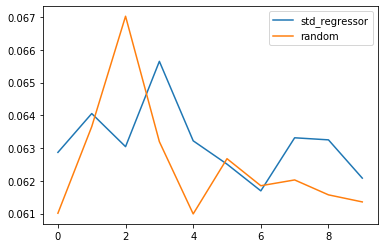

In [10]:
import matplotlib.pyplot as plt

plt.figure()

for af, mse in test_mses.items():
    plt.plot(mse, label=af)

plt.legend()

<IPython.core.display.Javascript object>


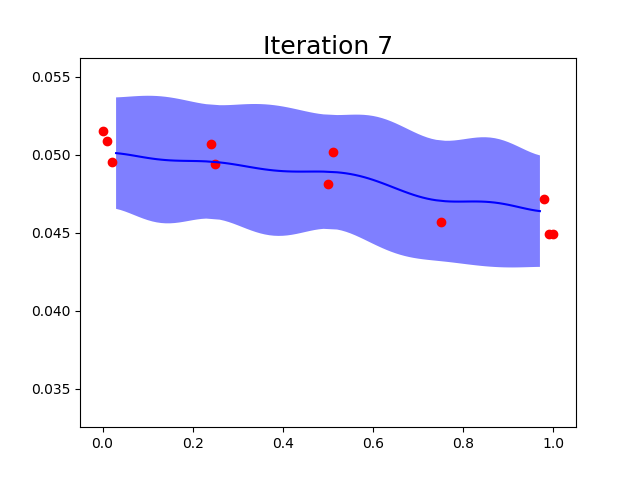

In [18]:
from celluloid import Camera
from IPython.core.display import HTML

%matplotlib notebook

learner = learners['std_regressor']
camera = Camera(plt.figure())

for i, item in enumerate(learner.gp_history, 1):
    plt.plot(item['X_train'], item['y_train'], 'ro')
    plt.plot(item['X_test'], item['mean'], 'b')
    plt.fill_between(item['X_test'].squeeze(),
                    item['mean'] - item['std'],
                    item['mean'] + item['std'],
                    alpha=.5, fc='b', ec='None')
    ax = plt.gca()
    ax.text(0.5, 1.01, f'Iteration {i}', transform=ax.transAxes, fontsize=18, ha='center')
    camera.snap()

animation = camera.animate(interval=1000)

<IPython.core.display.Javascript object>


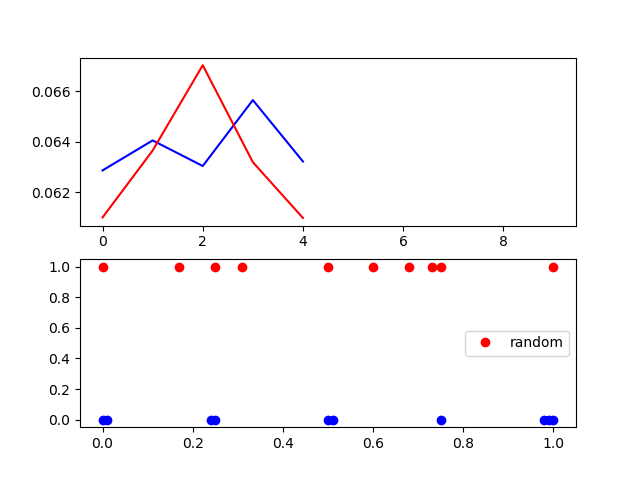

In [16]:
fig, axarr = plt.subplots(2)
camera = Camera(fig)

for i in range(1, n_iter+1):
    colors = ['b', 'r']
    dots = {}
    for j, (af, learner) in enumerate(learners.items()):
        learner.test_history['mse'].iloc[:i].plot(ax=axarr[0], color=colors[j], label=af)
        dots[af] = (axarr[1].plot(learner.trialed_thetas[:i + 5], [j]*(i+5), 'o'+colors[j], label=af))
    
    for af, dot_set in dots.items():
        plt.legend(dot_set, [af])
    camera.snap()


camera.animate(interval=1000)